# 项目2：神经网络数据分析
* 了解共享单车数据
* 现在你就是一位共享单车运营方的数据分析师
* 构建神经网络
* 使用已有数据对未来数据进行预测
* 测试你的结果
* 数据下载地址：https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

![bike](pic/bike.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1、读取数据
* 使用pandas可以读取各种数据

In [3]:
# 路径记得自行修改
data_path ='data/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 2、数据处理
* pandas可以进行索引
* 并可以直接 plot

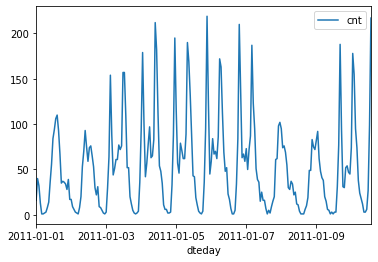

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### 数据整形
* 数据中有许多不适合运算的部分, 例如season，可以对其进行 onehot 处理
* pandas 的 get_dummies() 方法可以进行 onehot 处理
* pandas 的 concat() 方法可以对数据进行嫁接
* 处理完后不要忘记使用 drop() 方法将原始列丢弃掉

In [5]:
# onehot 处理
onehot_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in onehot_fields:
    onehot = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, onehot], axis=1)

# 丢弃原始列
drop_fields = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(drop_fields, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 数值规范化
* 有时需要把数据规范在0~1之间
* 一种常用的规范化算法就是将每个数据减去平均值后再除以标准差
* pandas 可以直接通过列名进行索引

In [11]:
need_norm = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
save_norm = {}
for one in need_norm:
    mean, std = data[one].mean(), data[one].std()
    save_norm[one] = [mean, std]
    data.loc[:, one] = (data[one] - mean)/std

### 划分训练数据集、测试数据集与验证数据集
这里把源数据划分为3份：
* 一份测试数据集，本次使用21天的数据，用于训练过程结束后，测试我们的网络是否能面对没见过的数据预测出比较好的效果；
* 一份验证数据集，本次使用60天的数据，用于在训练过程中，计算每一次迭代我们的神经网络当前状态对于新数据的误差；
* 一份训练数据集，剩余所有数据，用于训练。   

划分好后记得查看一下各个数据的shape，确保正确。

In [12]:
# 保留21天测试数据
test_data = data[-21*24:]
data = data[:-21*24]

# 分离特征与标签
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 划分验证集和训练集
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## 3、构建神经网络

这里我们将构建一个神经网络的类，该类存在以下方法：
1. \_\_init\_\_方法，默认方法，接收参数（每一层神经元数目，学习速率等），并设置一个选择激活函数的开关；
2. sigmoid函数，计算出sigmoid值；
3. train方法，训练方法，包含前传、反传、误差计算、梯度计算、各层梯度更新的过程；
4. run方法，测试方法，完成一次前传计算出最后的预测值即可。

In [13]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # 设置神经元节点数量
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # 初始化权重
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
                
        # 设定激活函数
        self.activation_function = self.sigmoid
    
    def sigmoid(self , x):
        return 1 / (1 + np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # 数据形状转换
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # shape of inputs (56,1) #
        # shape of weights_input_to_hidden (2, 56) #
        # shape of weights_hidden_to_output (1, 2) #
        
        ### 前传前传！ ###
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden , inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output , hidden_outputs)
        final_outputs = final_inputs
        
        ### 反传反传！ ###
        # 计算最后一层误差
        output_errors = (targets - final_outputs) * 1
        
        # 计算隐含层误差与梯度
        hidden_errors = (self.weights_hidden_to_output).T * output_errors * hidden_outputs * (1-hidden_outputs)
        hidden_grad = np.dot( hidden_errors ,inputs.T )
        
        # 更新权值
        self.weights_hidden_to_output += self.lr * np.dot(output_errors , hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * hidden_grad
 
        
    def run(self, inputs_list):
        # 进行一次前传
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden , inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output , hidden_outputs)
        final_outputs = final_inputs
        
        return final_outputs

In [14]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## 4、开始训练

这里需要设定一些超参：
* 迭代次数 epochs
* 学习速率 learning_rate
* 隐藏层神经元数量 hidden_nodes
* 输出层神经元数量 output_nodes
并且为了提高速度而且避免数据定式规律对结果的影响，这里每次迭代从训练集随机选取一定数据即可。

In [15]:
import sys

## 设定超参！ ##
epochs = 200
learning_rate = 0.9
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # 获取128个数据作为一个 batch
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # 下面的代码是为了可视化每次迭代的训练与验证的Loss，以便我们观看模型的训练状态
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


Progress: 99.5% ... Training loss: 0.370 ... Validation loss: 0.906

(0.2171845517917836, 1.0)

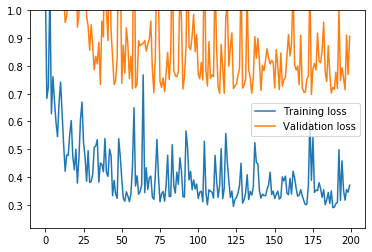

In [16]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=1.0)

## 5、数据预测

这里我们就使用测试集数据，进行数据预测。

D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


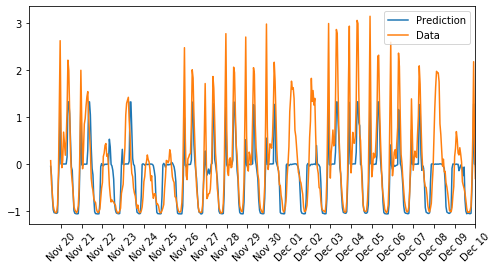

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = save_norm['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)